# NLP pipeline to analyse sentiment of tweets for Indian Railways


In [8]:
import nltk
nltk.download("punkt_tab")
import pandas as pd
import matplotlib.pyplot as plt
import re , collections , string , time , random
import seaborn as sns

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sanketmishra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [54]:
df = pd.read_csv("./data/train.csv" , encoding = 'latin1' , skiprows = 1 , names = ['index' , 'sentiment' , 'tweet'])
df.drop(columns=['index'] , inplace= True)
df.head()

,sentiment,tweet
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...
2,0,@RailMinIndia I'm traveling to chennai by trai...
3,5,@RailMinIndia irctc is not responding at the t...
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...


## Basic EDA


In [56]:
#display schema and null check
print(f"{df.info()} \n, {df.isnull().sum()}")

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366 entries, 0 to 1365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  1366 non-null   int64 
 1   tweet      1366 non-null   object
dtypes: int64(1), object(1)
memory usage: 21.5+ KB
None 
, sentiment    0
tweet        0
dtype: int64


,sentiment,tweet
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...
2,0,@RailMinIndia I'm traveling to chennai by trai...
3,5,@RailMinIndia irctc is not responding at the t...
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...


### Plot the distributions of sentiment labels and tweet length:


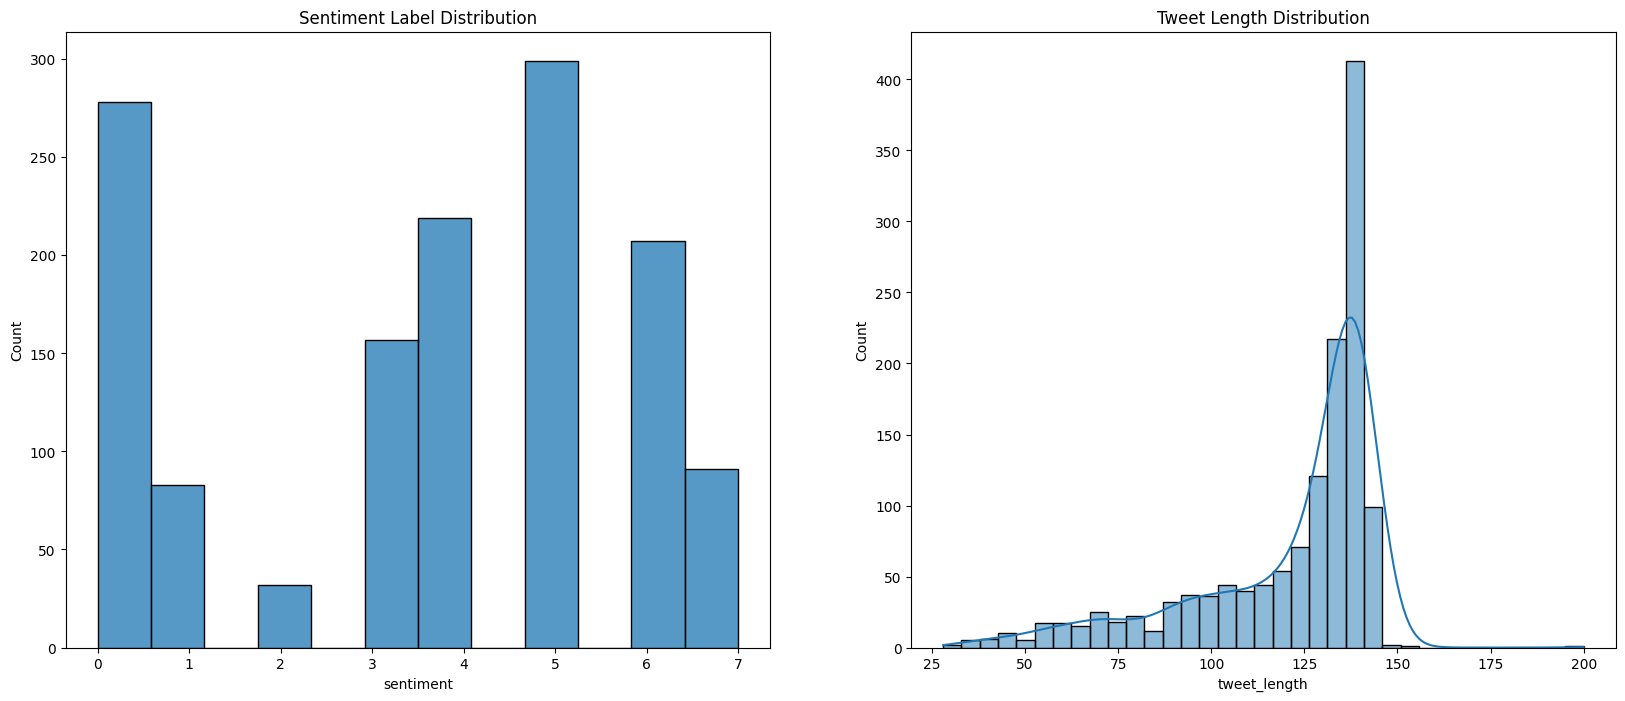

In [57]:
figure = plt.figure(figsize = (20,8))
plt.subplot(1 , 2, 1)
sns.histplot(data = df , x = 'sentiment')
plt.title("Sentiment Label Distribution")

plt.subplot(1 , 2, 2)
df['tweet_length'] = df['tweet'].apply(len)
sns.histplot(data = df , x = 'tweet_length' , kde = True)
plt.title("Tweet Length Distribution")
plt.show()

### Observations:

- Dataset contains 1336 labeled tweets

* Sentiment levels range from 0(negative) to 7(positive).
* Majority of tweets fall b/w 0-5 range, indicating complaints and neutral tweets.
* Some tweets have high sentiment scores, indicating appreciation.
* Average tweet length is 140 words , with a few outliers crossing 200 words mark.


## Cleaning and Feature Engineering:


In [58]:
# handle mention extraction:

def extractHandle(tweet):
    pattern = r"@\w+"
    return re.findall(pattern , tweet)

df['mentions'] = df['tweet'].apply(extractHandle)
df.head()

,sentiment,tweet,tweet_length,mentions
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia]
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]"
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia]
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia]
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ..."


In [59]:
# sample tweets for experimentation:
samples = df['tweet'].sample(100 , replace = False)
samples

1270    @RailMinIndia @ManiarSonam Mam, FIR has been l...
1311    @sureshpprabhu @RailMinIndia, No Refund for W/...
1357    @sureshpprabhu @RailMinIndia No water in coach...
1250    @RailMinIndia @RailwayNorthern Why the train s...
691     Please take up my case too, I just cant keep c...
                              ...                        
1214    @RailMinIndia spreading foodfor service at was...
704     @RailMinIndia Train No 09810 Coach B1. AC not ...
744     RT @princebiet: 2 hours journey completed in 6...
866     @Cleartrip If u want ticket print i can DM to ...
596     big mouse found below the berth,plz help. Cant...
Name: tweet, Length: 100, dtype: object

In [66]:
#hashtag extraction:

def extractHashtag(tweet):
    pattern = r"(?<!\w)#(\w+)"
    tags =  re.findall(pattern , tweet)
    # for tag in tags:
    #     tag.lower()

    tags = set(tags)
    return [tag.lower() for tag in tags]

# for tweet in samples:
#     print(extractHashtag(tweet))

df['hashtags'] = df['tweet'].apply(extractHashtag)
df.head(20) 

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"@RailMinIndia My PNR is 8348062961, I am in wa..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],@sureshpprabhu @RailMinIndia AC not working in...
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],@RailMinIndia I'm traveling to chennai by trai...
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],@RailMinIndia irctc is not responding at the t...
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...
5,6,@RailMinIndia If you can't give justice to gra...,127,[@RailMinIndia],[],[],@RailMinIndia If you can't give justice to gra...
6,4,@sureshpprabhu @RailMinIndiaPlz wrkout smthng ...,139,"[@sureshpprabhu, @RailMinIndiaPlz]",[],[],@sureshpprabhu @RailMinIndiaPlz wrkout smthng ...
7,0,@RailMinIndia @mumbairailusers Dirty water flo...,131,"[@RailMinIndia, @mumbairailusers]",[],[https://t.co/mBZUOFkLXQ],@RailMinIndia @mumbairailusers Dirty water flo...
8,6,Enter to win $150 Amazon Gift Card! #Books #PN...,94,[],"[pnr, books, romance, urbanfantasy]",[https://t.co/jBfXzDe7P2],Enter to win $150 Amazon Gift Card! #Books #PN...
9,3,@RailMinIndia still vendors are selling local ...,117,[@RailMinIndia],[],[https://t.co/wdFyLlmMek],@RailMinIndia still vendors are selling local ...


In [79]:
#extract urls and create a clean text column:

def extractUrl(tweet):
    pattern = r"https?://\S+"
    urls = set(re.findall(pattern , tweet))
    return [*urls]
df['urls'] = df['tweet'].apply(extractUrl)
df['clean_tweet'] = df['tweet'].apply(lambda x : re.sub(r"https?://\S+" , "" , x))
df


,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"@RailMinIndia My PNR is 8348062961, I am in wa..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],@sureshpprabhu @RailMinIndia AC not working in...
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],@RailMinIndia I'm traveling to chennai by trai...
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],@RailMinIndia irctc is not responding at the t...
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...
...,...,...,...,...,...,...,...
1361,5,@RailMinIndia An aged lady has been alloted up...,137,[@RailMinIndia],[],[],@RailMinIndia An aged lady has been alloted up...
1362,1,"aggressive copassengers, need of immediate cha...",72,[],[],[],"aggressive copassengers, need of immediate cha..."
1363,0,@RailMinIndia no water in coach...please do so...,130,[@RailMinIndia],[],[],@RailMinIndia no water in coach...please do so...
1364,3,@RailMinIndia @sureshpprabhu While travelling ...,133,"[@RailMinIndia, @sureshpprabhu]",[],[],@RailMinIndia @sureshpprabhu While travelling ...


In [82]:
#replace emojis with text form in clean text:
import emoji
df['clean_text'] = df['clean_tweet'].apply(lambda x : emoji.demojize(x , delimiters= (" :" , ": ")))
df['clean_text'] = df['clean_tweet'].str.replace(r":\w+:" , '' , regex = True)
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"@RailMinIndia My PNR is 8348062961, I am in wa...","@RailMinIndia My PNR is 8348062961, I am in wa..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @RailMinIndia AC not working in...
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],@RailMinIndia I'm traveling to chennai by trai...,@RailMinIndia I'm traveling to chennai by trai...
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],@RailMinIndia irctc is not responding at the t...,@RailMinIndia irctc is not responding at the t...
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...


## Pre-processing with nltk and spacy:


In [86]:
from nltk.tokenize import word_tokenize
import spacy

nlp = spacy.load("en_core_web_lg")

samples = df.sample(n = 100)['clean_text']

ntokens = samples.apply(word_tokenize)
stokens = samples.apply(lambda x : [token.text for token in nlp(x)])

for i in range(5):
    print(f"{samples.iloc[i]} \n, {ntokens.iloc[i]} \n , {stokens.iloc[i]}\n")

@RailMinIndia  Train no: 12017. Pnr: 2646724070. Reserved 2 tckts, 1 wtng. If only chair seats, then why allow waiting in shatabdi trains. 
, ['@', 'RailMinIndia', 'Train', 'no', ':', '12017', '.', 'Pnr', ':', '2646724070', '.', 'Reserved', '2', 'tckts', ',', '1', 'wtng', '.', 'If', 'only', 'chair', 'seats', ',', 'then', 'why', 'allow', 'waiting', 'in', 'shatabdi', 'trains', '.'] 
 , ['@RailMinIndia', ' ', 'Train', 'no', ':', '12017', '.', 'Pnr', ':', '2646724070', '.', 'Reserved', '2', 'tckts', ',', '1', 'wtng', '.', 'If', 'only', 'chair', 'seats', ',', 'then', 'why', 'allow', 'waiting', 'in', 'shatabdi', 'trains', '.']

@RailMinIndia @sureshpprabhu my wife's golden chain (mangal sutra) snatched in train. PNR:8402856864. Location ..  
, ['@', 'RailMinIndia', '@', 'sureshpprabhu', 'my', 'wife', "'s", 'golden', 'chain', '(', 'mangal', 'sutra', ')', 'snatched', 'in', 'train', '.', 'PNR:8402856864', '.', 'Location', '..'] 
 , ['@RailMinIndia', '@sureshpprabhu', 'my', 'wife', "'s", 'golden

In [88]:
#stemming using porter stemmer:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
# df['setmmed_text']
df['stemmed_text'] = df['clean_text'].apply(lambda x : " ".join([stemmer.stem(word) for word in x.split()]))
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"@RailMinIndia My PNR is 8348062961, I am in wa...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],@RailMinIndia I'm traveling to chennai by trai...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],@RailMinIndia irctc is not responding at the t...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...


In [90]:
#lemmatize using spacy lemmatizer:
df['lemmatized_text'] = df['clean_text'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"@RailMinIndia My PNR is 8348062961, I am in wa...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],@RailMinIndia I'm traveling to chennai by trai...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],@RailMinIndia irctc is not responding at the t...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...


In [92]:
#get pos tags:
df['pos_tags'] = df['clean_text'].apply(lambda x : [(word.text , word.pos_ , word.tag_) for word in nlp(x)])
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text,pos_tags
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"@RailMinIndia My PNR is 8348062961, I am in wa...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w...","[(@RailMinIndia, NOUN, NNS), (My, PRON, PRP$),..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...,"[(@sureshpprabhu, PROPN, NNP), (@RailMinIndia,..."
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],@RailMinIndia I'm traveling to chennai by trai...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...,"[(@RailMinIndia, NOUN, NNS), (I, PRON, PRP), (..."
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],@RailMinIndia irctc is not responding at the t...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...,"[(@RailMinIndia, NOUN, NNS), (irctc, PROPN, NN..."
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,"[(@DRMbhopal, PROPN, NNP), (@RailMinIndia, PRO..."


In [100]:
#average processing time per tweet:
import time
startt = time.time();

for i in range(100):
    for tweet in samples:
        [word.lemma_ for word in nlp(tweet)]
endt = time.time()

avgt = (endt - startt)/ (100 * samples.shape[0])

print(f"Average tweet processing time: {avgt=}")

Average tweet processing time: avgt=0.004156216502189636


## Name Entity Recognizitation and Domain Mapping:


In [105]:
def extractEntities(tweet):
    doc = nlp(tweet)
    return [(entity.text , entity.label_) for entity in doc.ents]

df['entities'] = df['clean_text'].apply(extractEntities)
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text,pos_tags,enitites,entities
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"@RailMinIndia My PNR is 8348062961, I am in wa...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w...","[(@RailMinIndia, NOUN, NNS), (My, PRON, PRP$),...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961..."
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...,"[(@sureshpprabhu, PROPN, NNP), (@RailMinIndia,...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray..."
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],@RailMinIndia I'm traveling to chennai by trai...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...,"[(@RailMinIndia, NOUN, NNS), (I, PRON, PRP), (...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-..."
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],@RailMinIndia irctc is not responding at the t...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...,"[(@RailMinIndia, NOUN, NNS), (irctc, PROPN, NN...","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, ORG), (irctc, ORG)]"
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,"[(@DRMbhopal, PROPN, NNP), (@RailMinIndia, PRO...",[],[]


In [108]:
entities = df['entities']
sset = set()
entities.apply(lambda x : [sset.add((text , label))for text , label in x])
sset

{('1st', 'ORDINAL'),
 ('Samatha', 'PERSON'),
 ('no12310', 'GPE'),
 ('INDIA', 'GPE'),
 ('AC &amp', 'ORG'),
 ('FearOfDelayed', 'MONEY'),
 ('Hellcat ð\x9f\x92\x95Quirky Veterinarian ð\x9f\x91', 'PERSON'),
 ('Coaches &amp', 'ORG'),
 ('lodge', 'PERSON'),
 ('baje ki', 'PERSON'),
 ('08305008854', 'CARDINAL'),
 ('2-3', 'CARDINAL'),
 ('3+ hr', 'QUANTITY'),
 ('MSH', 'ORG'),
 ('73', 'CARDINAL'),
 ('awadh assam exp PNR 2817784641', 'ORG'),
 ('@GM_CRly', 'NORP'),
 ('ex0', 'LAW'),
 ('frm Mum', 'PERSON'),
 ('Vikhroli', 'GPE'),
 ('@sureshpprabhu Train', 'ORG'),
 ('BNY', 'ORG'),
 ('12396', 'CARDINAL'),
 ('2', 'CARDINAL'),
 ('PSO @IrishRail', 'ORG'),
 ('12344', 'DATE'),
 ('Divyanshu Mob.7847932526', 'PERSON'),
 ('@PMOIndia', 'ORG'),
 ('Railway Station', 'FAC'),
 ('No Berth', 'ORG'),
 ('@RailMinIndia 3rd ac', 'ORG'),
 ('TNDE', 'ORG'),
 ('pnr', 'PRODUCT'),
 ('Maveli Express', 'ORG'),
 ('4631896219', 'DATE'),
 ('one and half hours', 'TIME'),
 ('RT @RupSgsits: @RailMinIndia', 'ORG'),
 ('341', 'CARDINAL'),
 

In [111]:
def mapDomain(entities):
    mapped = []
    for text , label in entities:
        if label == "GPE":
            mapped.append((text , 'STATION'))
        elif label == 'CARDINAL' and len(text) > 2:
            mapped.append((text , "TRAIN_NO"))
        elif label == "ORDINAL":
            mapped.append({text , 'COACH'})
        elif text.lower() in ['water' , 'ac' , 'cleanliness' , 'toilet']:
            mapped.append((text , 'SERVICE'))
        else:
            mapped.append((text , 'OTHER'))
        return mapped
    
df['domain_entities'] = df['entities'].apply(mapDomain)
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text,pos_tags,enitites,entities,domain_entities
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"@RailMinIndia My PNR is 8348062961, I am in wa...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w...","[(@RailMinIndia, NOUN, NNS), (My, PRON, PRP$),...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, OTHER)]"
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...,"[(@sureshpprabhu, PROPN, NNP), (@RailMinIndia,...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, OTHER)]"
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],@RailMinIndia I'm traveling to chennai by trai...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...,"[(@RailMinIndia, NOUN, NNS), (I, PRON, PRP), (...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, OTHER)]"
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],@RailMinIndia irctc is not responding at the t...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...,"[(@RailMinIndia, NOUN, NNS), (irctc, PROPN, NN...","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, OTHER)]"
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,"[(@DRMbhopal, PROPN, NNP), (@RailMinIndia, PRO...",[],[],None


In [115]:
!pip install vaderSentiment afinn nrclex

In [136]:
def cleanTweet(tweet):
    tweet = re.sub(r"RT" , "" , tweet)
    tweet = re.sub(r"#\S+" , "" , tweet)
    tweet = re.sub(r"@\S+" , "" , tweet)
    return tweet
df['clean_tweet'] = df['clean_text'].apply(cleanTweet)
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text,pos_tags,enitites,entities,domain_entities
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"My PNR is 8348062961, I am in way but there i...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w...","[(@RailMinIndia, NOUN, NNS), (My, PRON, PRP$),...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, OTHER)]"
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],AC not working in prayag lucknow intercity t...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...,"[(@sureshpprabhu, PROPN, NNP), (@RailMinIndia,...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, OTHER)]"
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],I'm traveling to chennai by train 16102 coach...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...,"[(@RailMinIndia, NOUN, NNS), (I, PRON, PRP), (...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, OTHER)]"
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],irctc is not responding at the time of tatkal...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...,"[(@RailMinIndia, NOUN, NNS), (irctc, PROPN, NN...","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, OTHER)]"
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],Matter notified to concerned official,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,"[(@DRMbhopal, PROPN, NNP), (@RailMinIndia, PRO...",[],[],None


In [143]:
# Get score of every lexicon in a separate column: 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from afinn import Afinn
from nrclex import NRCLex

af = Afinn()

sia = SentimentIntensityAnalyzer()

def getVader(tweet):
    return sia.polarity_scores(tweet)['compound']

def getAfinn(tweet):
    return af.score(tweet)

def getNrc(tweet):
    emotion = NRCLex(tweet)
    return sum(emotion.affect_frequencies.values())


df['vader_score'] = df['clean_tweet'].apply(getVader)
df['afinn_score'] = df['clean_tweet'].apply(getAfinn)
df['nrc_score'] = df['clean_tweet'].apply(getNrc)
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text,pos_tags,enitites,entities,domain_entities,vader_score,afinn_score,nrc_score
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"My PNR is 8348062961, I am in way but there i...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w...","[(@RailMinIndia, NOUN, NNS), (My, PRON, PRP$),...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, OTHER)]",-0.4767,-2.0,1.0
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],AC not working in prayag lucknow intercity t...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...,"[(@sureshpprabhu, PROPN, NNP), (@RailMinIndia,...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, OTHER)]",-0.2235,-1.0,1.0
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],I'm traveling to chennai by train 16102 coach...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...,"[(@RailMinIndia, NOUN, NNS), (I, PRON, PRP), (...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, OTHER)]",0.0000,-2.0,1.0
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],irctc is not responding at the time of tatkal...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...,"[(@RailMinIndia, NOUN, NNS), (irctc, PROPN, NN...","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, OTHER)]",0.0000,0.0,1.0
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],Matter notified to concerned official,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,"[(@DRMbhopal, PROPN, NNP), (@RailMinIndia, PRO...",[],[],None,0.0258,-1.0,1.0


In [144]:
#determine the polarity of each score:
threshold = 0.05
df['vader_polarity'] = df['vader_score'].apply(lambda x : "positive" if x > threshold else 'negative')
df['afinn_polarity'] = df['afinn_score'].apply(lambda x : "positive" if x > threshold else 'negative')
df['nrc_polarity'] = df['nrc_score'].apply(lambda x : "positive" if x > threshold else 'negative')
df.head()


,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text,pos_tags,enitites,entities,domain_entities,vader_score,afinn_score,nrc_score,vader_polarity,afinn_polarity,nrc_polarity
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"My PNR is 8348062961, I am in way but there i...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w...","[(@RailMinIndia, NOUN, NNS), (My, PRON, PRP$),...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, OTHER)]",-0.4767,-2.0,1.0,negative,negative,positive
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],AC not working in prayag lucknow intercity t...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...,"[(@sureshpprabhu, PROPN, NNP), (@RailMinIndia,...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, OTHER)]",-0.2235,-1.0,1.0,negative,negative,positive
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],I'm traveling to chennai by train 16102 coach...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...,"[(@RailMinIndia, NOUN, NNS), (I, PRON, PRP), (...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, OTHER)]",0.0000,-2.0,1.0,negative,negative,positive
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],irctc is not responding at the time of tatkal...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...,"[(@RailMinIndia, NOUN, NNS), (irctc, PROPN, NN...","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, OTHER)]",0.0000,0.0,1.0,negative,negative,positive
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],Matter notified to concerned official,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,"[(@DRMbhopal, PROPN, NNP), (@RailMinIndia, PRO...",[],[],None,0.0258,-1.0,1.0,negative,negative,positive


In [148]:
# computer alingment -> if all three scores match or not:
def getalignment(row):
    x , y , z = row['vader_polarity'] , row['afinn_polarity'] , row['nrc_polarity']
    if x == y == z:
        return 1
    elif x == y or x == z or y == z: return 2/3
    else: return 0;

df['align'] = df.apply(getalignment , axis = 1)
df['balign'] = df['align'].apply(lambda x : 1 if x == 1 else 0)
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text,...,entities,domain_entities,vader_score,afinn_score,nrc_score,vader_polarity,afinn_polarity,nrc_polarity,align,balign
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"My PNR is 8348062961, I am in way but there i...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w...",...,"[(@RailMinIndia, ORG), (PNR, ORG), (8348062961...","[(@RailMinIndia, OTHER)]",-0.4767,-2.0,1.0,negative,negative,positive,0.666667,0
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],AC not working in prayag lucknow intercity t...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...,...,"[(@sureshpprabhu @RailMinIndia AC, ORG), (pray...","[(@sureshpprabhu @RailMinIndia AC, OTHER)]",-0.2235,-1.0,1.0,negative,negative,positive,0.666667,0
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],I'm traveling to chennai by train 16102 coach...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...,...,"[(@RailMinIndia, ORG), (16102, CARDINAL), (S4-...","[(@RailMinIndia, OTHER)]",0.0000,-2.0,1.0,negative,negative,positive,0.666667,0
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],irctc is not responding at the time of tatkal...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...,...,"[(@RailMinIndia, ORG), (irctc, ORG)]","[(@RailMinIndia, OTHER)]",0.0000,0.0,1.0,negative,negative,positive,0.666667,0
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],Matter notified to concerned official,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,...,[],None,0.0258,-1.0,1.0,negative,negative,positive,0.666667,0


In [150]:
#compare b/w aligned and non-aligned tweets:
aligned = df[df['balign'] == 1]
naligned = df[df['balign'] == 0]
print(f"Total tweets: {df.shape[0]} \n Aligned tweets: {aligned.shape[0]} \n Non-Aligned tweets: {naligned.shape[0]} ")
print(f"Agreement rate: {aligned.shape[0]/df.shape[0] * 100}")

Total tweets: 1366 
 Aligned tweets: 435 
 Non-Aligned tweets: 931 
Agreement rate: 31.844802342606148


In [159]:
# for each tweet record dominant emotion and produce bar chart of emotion count:
def getDominantEmotion(tweet):
    emotion = NRCLex(tweet)
    tscores = emotion.top_emotions
    if len(tscores) == 1:
        return tscores[0][0]
    else:
        return "None"

df['demotions'] = df['clean_tweet'].apply(getDominantEmotion)
df.head()

,sentiment,tweet,tweet_length,mentions,hashtags,urls,clean_tweet,clean_text,stemmed_text,lemmatized_text,...,domain_entities,vader_score,afinn_score,nrc_score,vader_polarity,afinn_polarity,nrc_polarity,align,balign,demotions
0,0,"@RailMinIndia My PNR is 8348062961, I am in wa...",140,[@RailMinIndia],[],[],"My PNR is 8348062961, I am in way but there i...","@RailMinIndia My PNR is 8348062961, I am in wa...","@railminindia my pnr is 8348062961, i am in wa...","@RailMinIndia my PNR be 8348062961 , I be in w...",...,"[(@RailMinIndia, OTHER)]",-0.4767,-2.0,1.0,negative,negative,positive,0.666667,0,None
1,0,@sureshpprabhu @RailMinIndia AC not working in...,137,"[@sureshpprabhu, @RailMinIndia]",[],[],AC not working in prayag lucknow intercity t...,@sureshpprabhu @RailMinIndia AC not working in...,@sureshpprabhu @railminindia ac not work in pr...,@sureshpprabhu @RailMinIndia AC not work in pr...,...,"[(@sureshpprabhu @RailMinIndia AC, OTHER)]",-0.2235,-1.0,1.0,negative,negative,positive,0.666667,0,None
2,0,@RailMinIndia I'm traveling to chennai by trai...,122,[@RailMinIndia],[],[],I'm traveling to chennai by train 16102 coach...,@RailMinIndia I'm traveling to chennai by trai...,@railminindia i'm travel to chennai by train 1...,@RailMinIndia I be travel to chennai by train ...,...,"[(@RailMinIndia, OTHER)]",0.0000,-2.0,1.0,negative,negative,positive,0.666667,0,positive
3,5,@RailMinIndia irctc is not responding at the t...,68,[@RailMinIndia],[],[],irctc is not responding at the time of tatkal...,@RailMinIndia irctc is not responding at the t...,@railminindia irctc is not respond at the time...,@RailMinIndia irctc be not respond at the time...,...,"[(@RailMinIndia, OTHER)]",0.0000,0.0,1.0,negative,negative,positive,0.666667,0,anticipation
4,7,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,104,"[@DRMbhopal, @RailMinIndia, @sanjaygupta2012, ...",[],[],Matter notified to concerned official,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,@drmbhopal @railminindia @sanjaygupta2012 @drm...,@DRMbhopal @RailMinIndia @sanjaygupta2012 @drm...,...,None,0.0258,-1.0,1.0,negative,negative,positive,0.666667,0,None


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'None'),
  Text(1, 0, 'positive'),
  Text(2, 0, 'anticipation'),
  Text(3, 0, 'negative'),
  Text(4, 0, 'trust'),
  Text(5, 0, 'fear'),
  Text(6, 0, 'sadness'),
  Text(7, 0, 'anger'),
  Text(8, 0, 'disgust')])

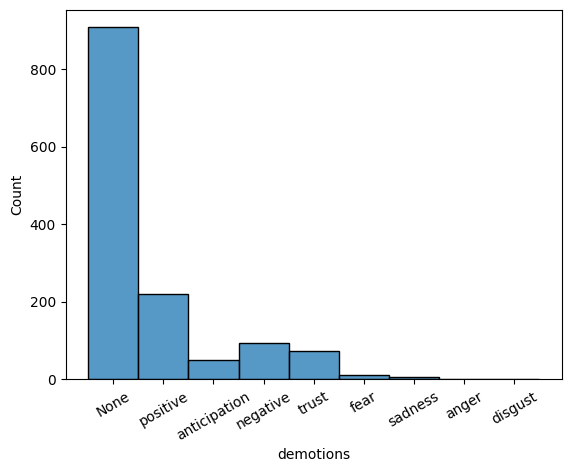

In [162]:
sns.histplot(df , x = 'demotions')
plt.xticks(rotation = 30)